In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [2]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [3]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('01011', -27.288260020000003), ('00111', -27.288260019999996), ('00101', -19.64648408)]


In [4]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [5]:
costs = []
np.random.seed(0)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

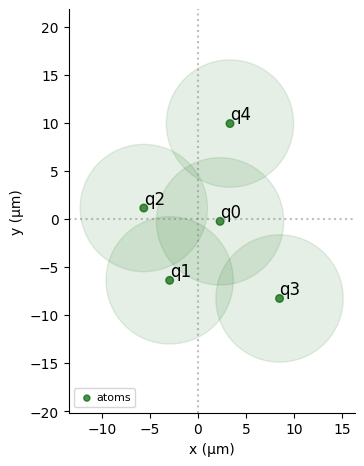

In [6]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

## Quantum Adiabatic Algorithm

In [8]:
# We choose a median value between the min and the max
Omega = np.median(Q[Q > 0].flatten())
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

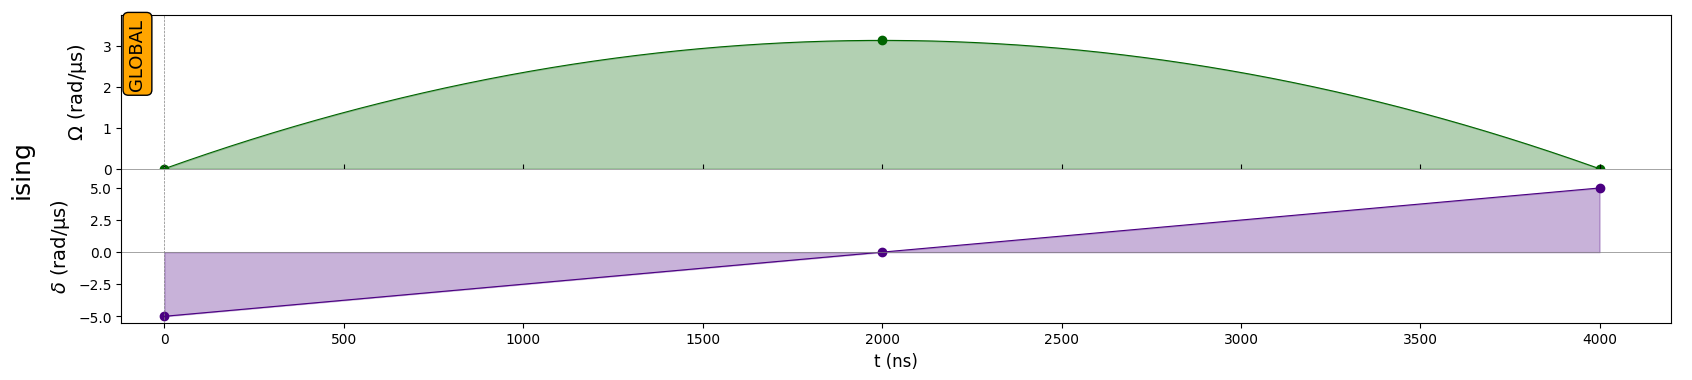

In [9]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [10]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [12]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

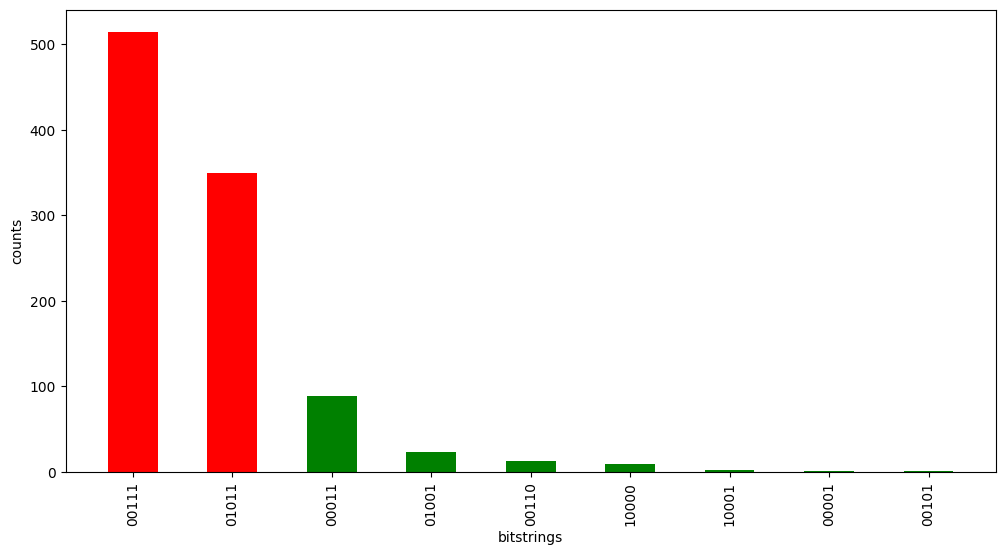

In [13]:
plot_distribution(count_dict)

In [15]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [ ]:
cost = []
nn = 10 # takes very long, can also set to 1
for T in 1000 * np.linspace(1, 25, 25*nn+1):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

/tmp/ipykernel_198619/381895014.py:6: UserWarning: A waveform duration of 1672.0000000000002 ns is below the supported precision of 1 ns. It was rounded down to 1672 ns.
  InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
/tmp/ipykernel_198619/381895014.py:7: UserWarning: A waveform duration of 1672.0000000000002 ns is below the supported precision of 1 ns. It was rounded down to 1672 ns.
  InterpolatedWaveform(T, [delta_0, 0, delta_f]),
/tmp/ipykernel_198619/381895014.py:6: UserWarning: A waveform duration of 1863.9999999999998 ns is below the supported precision of 1 ns. It was rounded down to 1863 ns.
  InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
/tmp/ipykernel_198619/381895014.py:7: UserWarning: A waveform duration of 1863.9999999999998 ns is below the supported precision of 1 ns. It was rounded down to 1863 ns.
  InterpolatedWaveform(T, [delta_0, 0, delta_f]),
/home/bigbogo/miniconda3/envs/pulser/lib/python3.12/site-packages/pulser/sequence/sequence.py:1281: UserWarning: A duration 

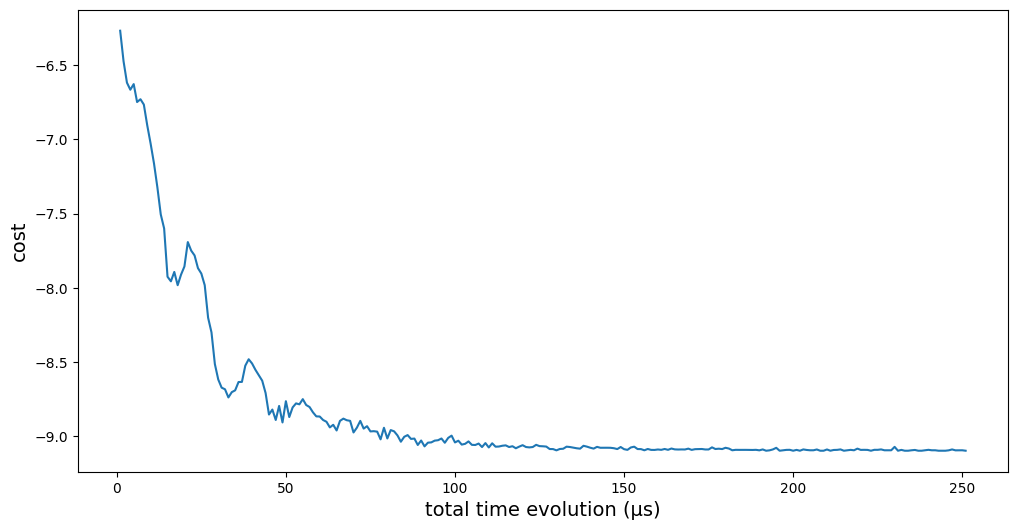

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cost)+1), np.array(cost))
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

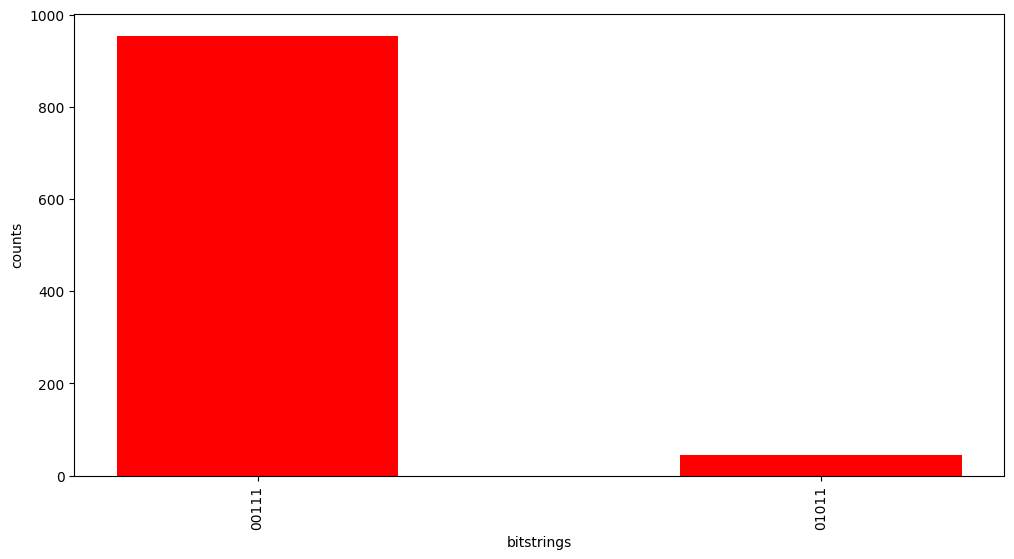

In [39]:
plot_distribution(count_dict) # last distribution

## Deep Dive into Embedding 

In [41]:
Q

array([[-10.        ,  19.7365809 ,  19.7365809 ,   5.42015853,
          5.42015853],
       [ 19.7365809 , -10.        ,  20.67626392,   0.17675796,
          0.85604541],
       [ 19.7365809 ,  20.67626392, -10.        ,   0.85604541,
          0.17675796],
       [  5.42015853,   0.17675796,   0.85604541, -10.        ,
          0.32306662],
       [  5.42015853,   0.85604541,   0.17675796,   0.32306662,
        -10.        ]])

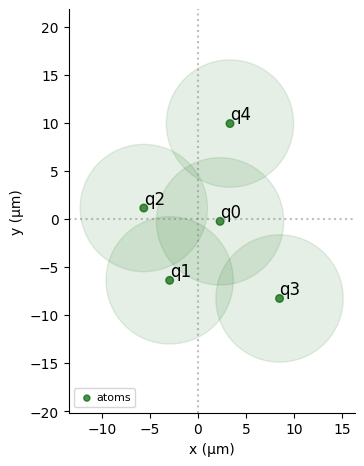

In [42]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [43]:
new_coords = np.reshape(coords, (len(Q), 2))
# computing the matrix of the distances between all coordinate pairs
new_Q = squareform(
    DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
)

In [51]:
print(new_coords.shape)
new_coords

(5, 2)


array([[ 2.31281516, -0.23002871],
       [-2.93655481, -6.36935057],
       [-5.62649393,  1.15594212],
       [ 8.49894067, -8.25563437],
       [ 3.34198769,  9.94592252]])

In [55]:
4+3+2+1

10

In [52]:
print(pdist(coords).shape)
print(pdist(coords))

(10,)
[ 8.07757129  8.05937615 10.13303977 10.22786291  7.99160826 11.59002257
 17.48165415 16.97367593 12.55776325 18.91800299]


In [58]:
squareform(pdist(coords))

array([[ 0.        ,  8.07757129,  8.05937615, 10.13303977, 10.22786291],
       [ 8.07757129,  0.        ,  7.99160826, 11.59002257, 17.48165415],
       [ 8.05937615,  7.99160826,  0.        , 16.97367593, 12.55776325],
       [10.13303977, 11.59002257, 16.97367593,  0.        , 18.91800299],
       [10.22786291, 17.48165415, 12.55776325, 18.91800299,  0.        ]])

In [45]:
new_Q

array([[ 0.        , 19.51314138, 19.77895915,  5.00695291,  4.73481048],
       [19.51314138,  0.        , 20.80687544,  2.23617763,  0.18989645],
       [19.77895915, 20.80687544,  0.        ,  0.22665043,  1.3820961 ],
       [ 5.00695291,  2.23617763,  0.22665043,  0.        ,  0.11823886],
       [ 4.73481048,  0.18989645,  1.3820961 ,  0.11823886,  0.        ]])